## lineqGPR: an R package for Gaussian process modelling with inequality constraints

---
OQUAIDO Scientific Meeting, November 26, 27 & 28 - 2019 <br>
Mines Saint-Etienne, France

In [1]:
library("lineqGPR")
library("DiceDesign")
library("plot3D")
library("viridis")

rm(list=ls())
colormap <- rev(viridis(1e2))
options(warn=-1)
set.seed(7)

Loading required package: nloptr
Loading required package: broom
Loading required package: tmg
Loading required package: mvtnorm
Loading required package: purrr
Loading required package: viridisLite


# 2D additive Gaussian process modelling with inequality constraints

### <font color='blue'> 2D toy example </font>

**Aim:** to approximate the function:
$$Y(x_1,x_2) = 4\left(x_1-\frac{1}{2}\right)^2 + 2 x_2.$$

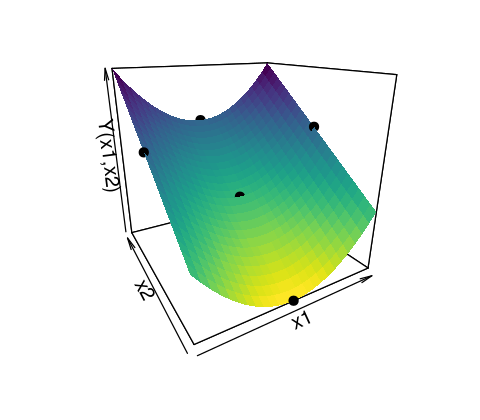

In [7]:
#### Synthetic data ####
targetFun <- function(x) return(4*(x[ ,1]-0.5)^2 + 2*x[ ,2])

xbase <- seq(0, 1, length = 25)
xgrid <- expand.grid(xbase, xbase)
ygrid <- targetFun(xgrid)
xdesign <- rbind(c(0.5,0), c(0.5,0.5), c(0.5,1), c(0,0.5), c(1,0.5))
ydesign <- targetFun(xdesign)

options(repr.plot.width = 4, repr.plot.height = 3.5) # size of the plot
persp3D(xbase, xbase, matrix(ygrid, nrow = length(xbase)),
        xlab = "x1", ylab = "x2", zlab = "Y(x1,x2)",
        phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(x = xdesign[,1], y = xdesign[,2], z = ydesign,
         col = "black", pch = 19, add = TRUE)

## Finite-dimensional approximation of additive Gaussian processes

Consider the centred additive GP $\{Y(\bf{x}); \bf{x} \in \mathcal{D}\}$ with covariance function $k$ and compact space $\mathcal{D} \in [0,1]^d$. Here, we aim at imposing some inequality constraints (e.g. boundedness, monotonicity, convexity) over $Y$. Consider $Y_{p, m_p}$ for $p = 1, \cdots, d$, as the piecewise linear approximation of $Y_p$ at knots $t_{1}^{(p)}, \cdots, t_{m_p}^{(p)}$:
$$
Y_{p, m_{p}}(x_p) = \sum_{j_p=1}^{m_p} \xi_{j_p}^{(p)} \phi_{j_p}^{(p)} (x_p),
$$
where $x_1, \cdots, x_d \in [0,1]$, $\xi_{j_{p}}^{(p)} := Y_p(t_{j_{p}}^{(p)})$, and $\phi_{1}^{(p)} \cdots, \phi_{m_p}^{(p)}$ are hat basis functions. Thus, the finite-dimensional approximation of GPs can be written as
$$
    Y_m(\textbf{x})
	= \sum_{p = 1}^d \sum_{j_{p}=1}^{m_{p}} \xi_{j_p}^{(p)} \phi_{j_{p}}^{(p)} (x_p).
$$

Here, we define $\boldsymbol{\xi}_{p} = [\xi_{1}^{(p)}, \cdots, \xi_{m_{p}}^{(p)}]^\top$, for $p = 1, \cdots, d$, as centred Gaussian vectors with covariance matrices $\boldsymbol{\Gamma}_{p} = (k_{p,m_{p}}(t_{i}^{(p)},t_{j}^{(p)}))_{1\leq i,j\leq m_{p}}$. We assume that the vectors $\boldsymbol{\xi}_{p}$'s are independent. Then, the covariance function of $Y_m$ is given by

$$
    k(\textbf{x}, \textbf{x}')	
    = \sum_{p = 1}^d \bigg(\sum_{i_{p}=1}^{m_{p}} \sum_{j_{p}=1}^{m_{p}} \phi_{i_{p}}^{(p)}(x_{p}) 	k_{p,m_{p}}(t_{i_{p}}^{(p)},{t_{j_{p}}^{(p)}}) \phi_{j_{p}}^{(p)}({x'_{p}})\bigg),
$$
with $\textbf{x},\textbf{x}' \in \mathcal{D}$. We refer to the Jupyter Notebook 1 for further information of the finite-dimensional approximation of standard GPs.

## Conditioning with interpolation and inequality constraints

Consider the finite representation $Y_m$ given the interpolation and inequality constraints,

$$
    Y_m(\textbf{x})
    =  \sum_{p = 1}^d \sum_{j_{p}=1}^{m_{p}} \xi_{j_{p}}^{(p)} \phi_{j_{p}}^{(p)} (x_p) \quad \mbox{s.t.} \quad \begin{cases} Y_m(\textbf{x}_i) + \varepsilon_i = y_i, \\ \boldsymbol{\xi}_{p} \in \mathcal{C}^{(p)}, \end{cases}
$$
where $\textbf{x}_i \in \mathcal{D}$, $y_i \in \mathbb{R}$ for $i = 1, \cdots, n$, and $\mathcal{C}^{(p)}$ a convex set of inequality constraints. Here, we consider an additive Gaussian noise $\varepsilon_i \sim \mathcal{N} (0, \tau^2)$ with noise variance $\tau^2$, and we assume that $\varepsilon_1, \cdots, \varepsilon_n$ are independent, and independent of $Y_m$. Given a DoE $\textbf{X} = [\textbf{x}_1, \cdots, \textbf{x}_n]^\top$, we have matricially:

$$
    \textbf{Y}_m = \begin{bmatrix} Y_m(\textbf{x}_1), & \cdots, & Y_m(\textbf{x}_n) \end{bmatrix}^\top  =  \sum_{p = 1}^d \boldsymbol{\Phi}_{p} \boldsymbol{\xi}_{p},
$$
with $\boldsymbol{\Phi}_{p}$ an $n \times m_{p}$ matrix defined by $(\boldsymbol{\Phi}_{p})_{i,j} = \phi_{j_{p}}^{(p)} (x_p^i)$. Denote $\boldsymbol{\Lambda}_{p} = (\lambda_{i,j}^{(p)})_{1 \leq i \leq q, 1 \leq j \leq m}$, $\textbf{l}_{p} = (l_{i}^{(p)})_{1 \leq i \leq q}$, and $\textbf{u}_{p} = (u_{i}^{(p)})_{1 \leq i \leq q}$ the set of linear inequality conditions of $\boldsymbol{\xi}_{p}$. Then, the distribution of $\boldsymbol{\xi}_{p}$, for $p = 1, \cdots, d$, given both interpolation and inequality conditions is truncated multinormal:

$$
    \boldsymbol{\xi}_{p} \sim \mathcal{N}(\boldsymbol{0},\boldsymbol{\Gamma}_{p}) \forall \; p = 1, \cdots, d \quad \mbox{s.t.} \quad  \begin{cases}  \sum\limits_{p = 1}^d \boldsymbol{\Phi}_{p} \boldsymbol{\xi}_{p} + \tau^2 \textbf{I} = \textbf{y} \\ \textbf{l}_{p} \leq \boldsymbol{\Lambda}_{p} \boldsymbol{\xi}_{p} \leq \textbf{u}_{p}. \end{cases}
$$

Finally, one can note that quantifying uncertainty on $Y_m$ relies on simulating $\boldsymbol{\xi}_p \big| \big\{\sum\limits_{p = 1}^d \boldsymbol{\Phi}_{p} \boldsymbol{\xi}_{p} + \tau^2 \textbf{I} = \textbf{y}, \; \textbf{l}_{p} \leq \boldsymbol{\Lambda}_{p} \boldsymbol{\xi}_{p} \leq \textbf{u}_{p}\big\}$. This is done via MC/MCMC algorithms for truncated multinormals.

### <font color='blue'> 2D example under monotonicity and convexity constraints</font>

Now, revisiting the 2D example, we need to define some arguments for the implementation of the "lineqAGP" model:

1. The class of the model: ```"lineqAGP"```.
2. The interpolation points: $(x_i,y_i)$ for $i = 1, \cdots, n$.
3. The type of inequality constraint per dimension: e.g. ```"monotonicity"``` or ```"convexity"```.
4. The type of the sampler (Hamiltonian Monte Carlo, HMC, is performed by default): ```model$localParam$sampler <- "HMC"```
5. We can fix the number of knots $m$ per dimension from the object of the model: ```model$localParam$m```.

In [8]:
#### Constrained model ####
# creating the "lineqAGP" model
d <- ncol(xdesign)
model <- create(class = "lineqAGP", x = xdesign, y = ydesign,
                constrType = c("convexity", "monotonicity"))
model$localParam$m <- rep(15, d)  # changing the (default) number of knots
# changing the covariance parameters per dimension
model$kernParam[[1]]$par <- c(1, 0.2)
model$kernParam[[2]]$par <- c(1, 0.2)
model$nugget <- 1e-5 # to avoid numerical errors
model$varnoise <- 1e-5 # defining noise variance

# simulating samples from the model
xtest  <- as.matrix(xgrid)
ytest <- targetFun(xtest)
pred <- predict(model, xtest)
sim.model <- simulate(model, nsim = 1e4, seed = 7, xtest = xtest)
sim.model$mc <- Reduce('+', sim.model$ysim)

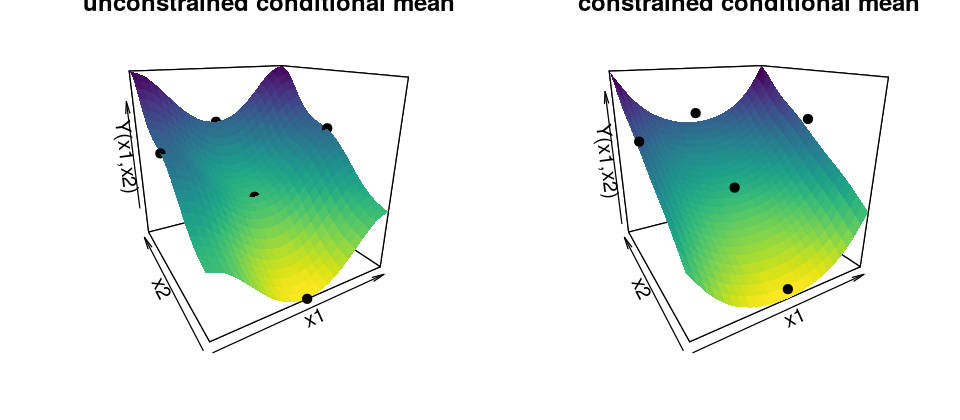

In [9]:
# plotting the results
options(repr.plot.width = 8, repr.plot.height = 3.5) # size of the plot
par(mfrow = c(1,2))

pred$m <- 0
for (k in 1:model$d)
    pred$m <- pred$m + pred$Phi.test[[k]] %*% pred$mu[, k]


# results using the unconstrained conditional mean
persp3D(x = xbase, y = xbase,
        z = matrix(pred$m, nrow = length(xbase)),
        xlab = "x1", ylab = "x2", zlab = "Y(x1,x2)",
        main = "unconstrained conditional mean",
        phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(x = xdesign[,1], y = xdesign[,2], z = ydesign,
         col = "black", pch = 19, add = TRUE)

# results using the constrained conditional mean
persp3D(x = unique(xtest[, 1]), y = unique(xtest[, 2]),
        z = matrix(rowMeans(sim.model$mc), nrow = length(xbase)),
        xlab = "x1", ylab = "x2", zlab = "Y(x1,x2)",
        main = "constrained conditional mean",        
        phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(x = xdesign[,1], y = xdesign[,2], z = ydesign,
         col = "black", pch = 19, add = TRUE)

# 2D application: Coastal flooding

In this sense, early warning and forecasting systems are key components for a coastal flooding risk assessment and
management. These are based on hydro-meteorological observations and modelling, aiming at anticipating the co-occurrence of such high-magnitude events and setting up accordingly preventive actions. To constrain these systems, the combinations of offshore conditions $\textbf{x}$ that generate a ''critical'' high water level at the coast (the maximum water level at the coast and the critical one are respectively denoted $\xi_{m}$ m and $\xi_{c}$) are of primary importance.

The study site is located on the Mediterranean coast, and it is characterised by a lido which is of primary importance both at an environmental and economic level for the region. This lido is protected from the sea, characterised by significant touristic activities. At the sea-front, there are pedestrian areas, which have already been flooded, at least during two storms: 6-8 November 1982 and the 4 December 2003.

The dataset used here contains 900 observations of the maximum water level at the coast $\xi_{m}$ depending on two input parameters: the offshore water level ($\xi_o$) and the wave height ($H_s$), both in metre units. The observations are taken within the domains $\xi_o \in [0.25, 1.50]$ and $H_s \in [0.5, 7]$ (with each dimension being discretized in 30 elements). We refer to (Rohmer and Idier, 2012) for a further discussion.

**References**

  1. Rohmer, J. and Idier, D. (2012).
  "A meta-modelling strategy to identify the critical offshore conditions for coastal flooding".
  *Natural Hazards Earth System Sciences*, 12:2943-2955.
  [[link]](https://www.nat-hazards-earth-syst-sci.net/12/2943/2012/)

In [5]:
library("DiceDesign")  # package for designs of experiments
library("lineqGPR")    # package GP regression under inequality constraints
library("plot3D")      # package for graphics and visualisation
library("viridis")     # package for graphics and visualisation
library("repr")        # package for graphics and visualisation
library("gridExtra")   # package for graphics and visualisation

rm(list=ls())
colormap <- rev(viridis(1e2))
options(warn=-1)
set.seed(7)

In this notebook, we aim at modelling the 2D example provided by (Rohmer and Idier, 2012) using Gaussian processes (GPs). One must note that the maximum water level $\xi_{m}$, on the domain considered for the input variables $\xi_o$ and $H_s$, satisfies both positivity and monotonicity (non-decreasing) constraints. Therefore, we here suggest a constrained GP model that accounts positivity and monotonicity conditions on both dimensions.

Next, we show 2D and 3D visualizations of the $\xi_{m}$ data.

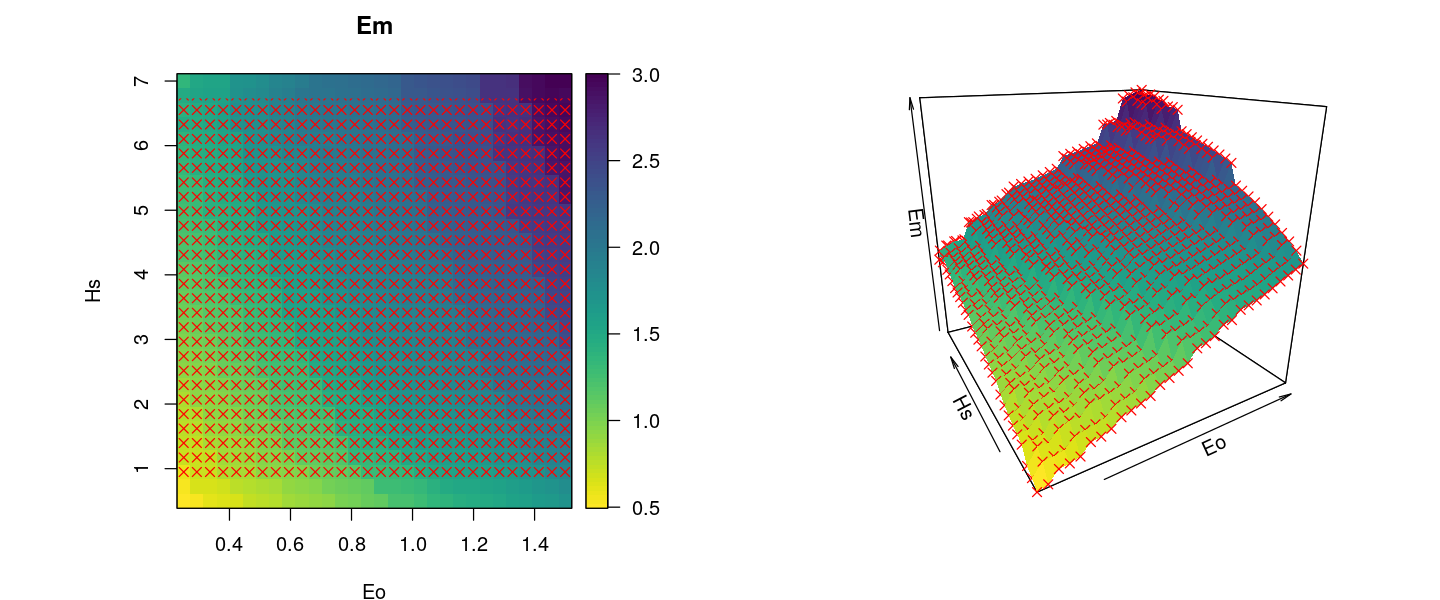

In [6]:
#### Loading 2D dataset ####
x <- read.table("notebooksDocs/DOE.txt", header = TRUE)
ngrid <- nrow(x) # nb discretised points per dimension (30 points)
d <- ncol(x) # nb dimensions
xgrid <- as.matrix(expand.grid(x[, 1], x[, 2])) # grid of observations
ygrid <- as.matrix(read.table("notebooksDocs/Y.txt")) # obs
nobs <- length(ygrid) #nb obs

## Plotting data ##
par(mfrow = c(1,2))
# 2D profile
options(repr.plot.width = 12, repr.plot.height = 5)
colormap <- rev(viridis(1e2))
image2D(x = unique(xgrid[, 1]), y = unique(xgrid[, 2]),
        z = matrix(ygrid, nrow = ngrid),
        xlab = "Eo", ylab = "Hs", main = "Em", col = colormap)
points(xgrid[, 1], xgrid[, 2], pch = 4, col = "red")
# 3D profile
p <- persp3D(x = unique(xgrid[, 1]), y = unique(xgrid[, 2]),
             z = matrix(ygrid, nrow = ngrid),
             xlab = "Eo", ylab = "Hs", zlab = "Em",
             phi = 20, theta = -30, col = colormap,
             colkey = FALSE)
points3D(x = xgrid[, 1], y = xgrid[, 2], z = ygrid,
         col = 'red', pch = 4, add = TRUE)

Now, we fit a GP model taking into account both positivity and monotonicity constraints. First, for illustrative purposes, we train a model using 5% of the data (equivalent to 45 training points chosen using a maximin Latin hypercube design), and we aim at predicting the remaining 95%. We use a squared exponential (SE) covariance function, and we estimate the covariance parameters via maximum likelihood (ML). We also estimate a noise variance (nugget effect). Since the computational complexity of the constrained GP model increases with the number of knots $m$ used for the finite-dimensional approximation, we fixed them aiming a trade-off between a high quality of resolution and computational cost. The automatic selection and location of the knots are of interest for further implementations (work in progress).

In [7]:
## scaling the input space to the unit square
xgrid[,1] <- (xgrid[,1] - min(xgrid[,1]))/max(xgrid[,1] - min(xgrid[,1]))
xgrid[,2] <- (xgrid[,2] - min(xgrid[,2]))/max(xgrid[,2] - min(xgrid[,2]))

## choosing training points
nb_doe <- 0.05*nobs # % of training points
x1 <- unique(xgrid[,1])
x2 <- unique(xgrid[,2])

design <- lhsDesign(n = nb_doe, d, seed = 7)$design
design <- maximinSA_LHS(design)$design # (optional)
design[,1] <- round((length(x1)-1)*design[,1]+1)
design[,2] <- round((length(x2)-1)*design[,2]+1)
design <- unique(design)
idxTrain <- length(x1)*(design[,2]-1) + design[,1]
xdesign <- xgrid[idxTrain, ]
ydesign <- ygrid[idxTrain]

xtest <- xgrid
ytest <- ygrid

In [8]:
#### training the model via maximum likelihood ####
model <- create(class = "lineqAGP", x = xdesign, y = ydesign,
                constrType = c("monotonicity", "monotonicity"))
model$localParam$m <- c(50, 50) # number of knots per dimension
# changing the (default) covariance parameters
model$varnoise <- 1e-3 # noise variance
model$nugget <- 1e-6 # to avoid numerical problems
for (i in 1:model$d)
    model$kernParam[[i]]$type <- "matern52"

# adding positivity constraints by forcing the first knot to be positive
model$lb <- c(0, model$lb)
model$ub <- c(Inf, model$ub)
model <- augment(model)
for (k in 1:model$d) {
    model$constrParam[[k]]$Lambda <- rbind(c(1, rep(0, ncol(model$constrParam[[k]]$Lambda)-1)),
                                           model$constrParam[[k]]$Lambda)
    model$constrParam[[k]]$lb <- c(0, model$constrParam[[k]]$lb)
    model$constrParam[[k]]$ub <- c(0, model$constrParam[[k]]$ub)
}
modelOpt <- lineqGPOptim(model,
                         x0 = unlist(purrr::map(model$kernParam, "par")),
                         eval_f = "logLik",
                         additive = TRUE,
                         opts = list(algorithm = "NLOPT_LD_MMA",
                                     print_level = 0,
                                     maxeval = 1e3,
                                     check_derivatives = FALSE),
                         lb = rep(1e-2, 2*d), ub = c(Inf, 10, Inf, 10),
                         estim.varnoise = TRUE,
                         bounds.varnoise = c(1e-7, Inf))
# simulating samples from the model
sim.model <- simulate(modelOpt, nsim = 1e3, seed = 7, xtest = xtest)
ysim <- Reduce('+', sim.model$ysim)

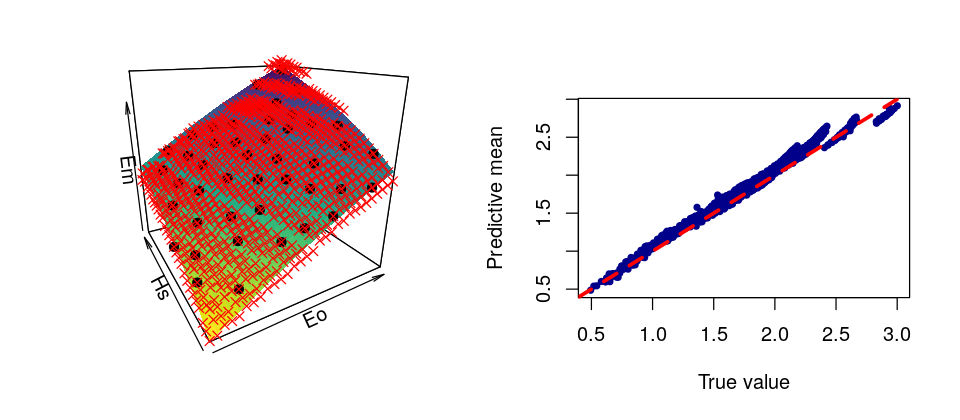

In [9]:
## plotting results for the additive model
par(mfrow = c(1,2))
options(repr.plot.width = 8, repr.plot.height = 3.5) # size of the plot

p <- persp3D(x = unique(xgrid[, 1]), y = unique(xgrid[, 2]),
             z =  matrix(rowMeans(ysim), nrow = length(unique(xgrid[, 1]))),
             xlab = "Eo", ylab = "Hs", zlab = "Em",
             phi = 20, theta = -30, col = colormap, colkey = FALSE)
points(trans3D(x = xdesign[, 1], y = xdesign[, 2], z = ydesign, pmat = p),
       pch = 19)
points(trans3D(x = xtest[, 1], y = xtest[, 2], z = ytest, pmat = p),
       col = 'red', pch = 4)

#### Assessing the quality of the predictive mean of the model ####
plot(ytest[-idxTrain], rowMeans(ysim)[-idxTrain],
     col = "darkblue", xlab = "True value", ylab = "Predictive mean",
     type = "p", pch = 20)
abline(a = 0, b = 1, col = "red", lty = 2, lwd = 3)

# 5D application: Coastal flooding

We test the performance of the constrained GP emulator on a 5D coastal flooding dataset provided by the BRGM (which is the French Geological Survey, "Bureau de Recherches Géologiques et Minières", in French). The data describe a 5D coastal flooding induced by overflow on the Atlantic coast, focusing on the inland flooded surface. We consider the "Boucholeurs" area located close to "La Rochelle", France. This area was flooded during the 2010 Xynthia storm, an event characterised by a high storm surge in phase with a high spring tide. We focus on those primary drivers, and on how they affect the resulting flooded surface (Azzimonti et al., 2019).

The dataset contains 200 observations of the flooded area $Y$ in $m^2$ depending on five input parameters $\textbf{x} = (T, S, \phi , t_{+} , t_{-})$ detailing the offshore forcing conditions:
- The tide is simplified by a sinusoidal signal parametrised by its high tide level $T \in [0.95, 3.70]$ ($m$).
- The surge signal is described by a triangular model using four parameters: the peak amplitude $S \in [0.65, 2.50]$ ($m$), the phase difference $\phi \in [-6, 6]$ (hours), between the surge peak and the high tide, the time duration of the raising part $t_{-} \in [-12.0, -0.5]$ (hours), and the falling part $t_{+} \in [0.5, 12.0]$ (hours).

The dataset is freely available in the R package **profExtrema** (Azzimonti, 2018). One must note that the flooded area $Y$ increases as $T$ and $S$ increase.

**References**

  1. Azzimonti, D., Ginsbourger, D., Rohmer, J., and Idier, D. (2019).
  "Profile extrema for visualizing and quantifying uncertainties on excursion regions. Application to coastal flooding".
  *Technometrics*, 0(ja):1–26.
  [[link]](https://doi.org/10.1080/00401706.2018.1562987)
  
  2. Azzimonti, D. (2018).
  profExtrema: Compute and Visualize Profile Extrema Functions.
  [[link]](https://cran.r-project.org/package=profExtrema)

In [10]:
library("profExtrema")  # package for flooding dataset
library("lineqGPR")     # package GP regression under inequality constraints
library("viridis")      # package for graphics and visualisation
library("plot3D")       # package for graphics and visualisation

rm(list=ls())    # cleaning global enrivonment
set.seed(7)      # fixing seed for numerical replications
options(warn=-1) # shutdown warnings

Loading required package: DiceKriging

Attaching package: ‘DiceKriging’

The following objects are masked from ‘package:lineqGPR’:

    logLikFun, logLikGrad

Loading required package: KrigInv
Loading required package: pGPx


## Numerical experiment

In this notebook, we aim at modelling the 5D example (Azzimonti et al., 2018) using Gaussian processes (GPs). One must note that, since $Y$ is monotone (non-decreasing) with respect to the inputs $T$ and $S$, we suggest a constrained GP model with monotonicity conditions on both dimensions.

First, we empirically analyse the dataset to evaluate which input variables $\textbf{x} = (T, S, \phi , t_{+} , t_{−})$ are more influential. We fit a linear regression model using the R function *lm*, and we assess the quality of model using the adjusted $R^2$ criterion. $R^2$ values close to one means that the model fits the data better. We also test various models when different input variables are considered (e.g. transformation of variables, or operation between them).


Call:
lm(formula = y ~ ., data = data.frame(x, y))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5949 -0.3719  0.1669  0.5017  1.0127 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.34197    0.26457  12.632  < 2e-16 ***
Tide         2.42183    0.22047  10.985  < 2e-16 ***
Surge        1.42740    0.18668   7.646 9.37e-13 ***
phi         -0.02982    0.19403  -0.154   0.8780    
tm          -0.27932    0.17387  -1.606   0.1098    
tp           0.28375    0.16598   1.710   0.0889 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6923 on 194 degrees of freedom
Multiple R-squared:  0.4191,	Adjusted R-squared:  0.4042 
F-statistic:    28 on 5 and 194 DF,  p-value: < 2.2e-16



Call:
lm(formula = y ~ .^2, data = data.frame(x, y))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.30765 -0.32702  0.06877  0.48148  0.98686 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.21065    0.97404   2.270  0.02439 * 
Tide         2.95871    1.03378   2.862  0.00470 **
Surge        2.92515    0.88611   3.301  0.00116 **
phi          1.19201    1.19300   0.999  0.31902   
tm           0.73733    0.86354   0.854  0.39430   
tp          -0.56661    0.81078  -0.699  0.48553   
Tide:Surge  -2.16147    0.87669  -2.465  0.01460 * 
Tide:phi     0.25964    1.12297   0.231  0.81741   
Tide:tm     -0.61167    0.76422  -0.800  0.42452   
Tide:tp      2.26211    0.73466   3.079  0.00239 **
Surge:phi   -0.34133    0.69733  -0.489  0.62508   
Surge:tm    -0.08747    0.64847  -0.135  0.89285   
Surge:tp     0.55383    0.61725   0.897  0.37075   
phi:tm      -0.81665    0.69643  -1.173  0.24246   
phi:tp      -1.58347    0.64741  -2.446  0.0153


Call:
lm(formula = y ~ . + I(phi^2) + I(Surge * (tp + tm)) + cos(2 * 
    pi * phi) + sin(2 * pi * phi), data = data.frame(x, y))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.00391 -0.19595  0.07614  0.33858  0.92074 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.90059    0.42250   6.865 9.16e-11 ***
Tide                  3.22547    0.17712  18.210  < 2e-16 ***
Surge                 1.97435    0.35698   5.531 1.04e-07 ***
phi                  -3.36138    1.86618  -1.801  0.07325 .  
tm                   -0.24444    0.21942  -1.114  0.26667    
tp                    0.68154    0.21931   3.108  0.00217 ** 
I(phi^2)              3.28324    1.84504   1.779  0.07676 .  
I(Surge * (tp + tm)) -0.35553    0.31731  -1.120  0.26394    
cos(2 * pi * phi)    -1.04477    0.19112  -5.467 1.43e-07 ***
sin(2 * pi * phi)     0.01649    0.08421   0.196  0.84493    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




Call:
lm(formula = y ~ . - phi + cos(2 * pi * phi), data = data.frame(x, 
    y))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.10727 -0.20746  0.05176  0.33826  0.81758 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.53712    0.19563  12.969  < 2e-16 ***
Tide               3.20154    0.17662  18.127  < 2e-16 ***
Surge              1.59191    0.14018  11.356  < 2e-16 ***
tm                -0.41665    0.13015  -3.201 0.001599 ** 
tp                 0.48024    0.12490   3.845 0.000163 ***
cos(2 * pi * phi) -0.71444    0.05794 -12.331  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5184 on 194 degrees of freedom
Multiple R-squared:  0.6743,	Adjusted R-squared:  0.6659 
F-statistic: 80.34 on 5 and 194 DF,  p-value: < 2.2e-16


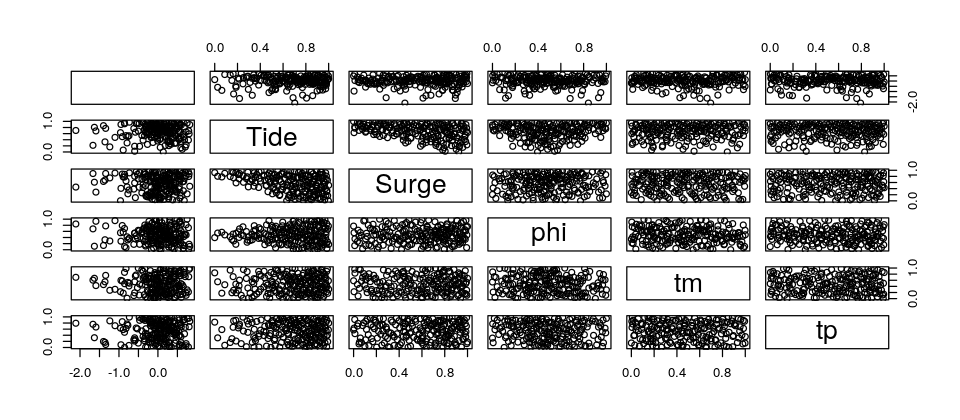

In [11]:
#### loading data ####
data <- as.matrix(coastal_flooding)
x <- data[ , -6] # considering all the input variables
colnames(x) <- c("Tide", "Surge", "phi", "tm", "tp")
# transforming the output in order to have small ranges.
y <- log10(data[, 6]) # area flooded
# this assumption is also made to account positivity conditions a priori.

# transforming input space into the unit square
for (k in 1:ncol(x))
  x[,k] <- (x[,k] - min(x[,k]))/max(x[,k] - min(x[,k]))

#### fitting different linear models to check active dimensions ####
# checking 1st order interaction
lm1 <- lm(y ~ ., data = data.frame(x, y)) # the influence of phi, tp and tm is not strong
summary(lm1)
# checking 2nd order interaction
lm2 <- lm(y ~ .^2, data = data.frame(x, y)) # there is no strong 2nd order influence
summary(lm2)
# testing new terms
lm3 <- lm(y ~ . + I(phi^2) + I(Surge*(tp + tm)) + # cos(2*pi*phi) improves the quality of the R^2
          cos(2*pi*phi) + sin(2*pi*phi), data = data.frame(x, y))
summary(lm3)

# "best" fitted model using cos(2*pi*phi) rather than
lm4 <- lm(y ~ . - phi + cos(2*pi*phi), data = data.frame(x, y))
summary(lm4)
pairs(cbind(residuals(lm4), x))

After testing different linear regression models, one can observe that their performance are more sensitive to the inputs $T$ and $S$ rather than to other ones. We can also note that, by transforming the phase coordinate $\phi \to \cos(2\pi\phi)$, $R^2$ improvements are obtained and the influence of both $t_{-}$ and $t_{+}$ becomes more significant. Next, we make use of this information for setting the GP models. 

**Note:** one must note that better GP models can be obtained making a further analysis and additional assumptions. However, our aim here is to assess the benefits of adding inequality constraints on standard GP implementations.

In [12]:
# building the dataset for the GP models
x <- data[, -6] # considering the whole input space
x[, 3] <- cos(2*pi*x[, 3]) # transforming the 3rd input
colnames(x) <- c("Tide", "Surge", "cosPhi", "tm", "tp")
d <- ncol(x) # nb dimensions
y <- log10(data[, 6])

# transforming input space into the unit square
for (k in 1:ncol(x))
  x[,k] <- (x[,k] - min(x[,k]))/max(x[,k] - min(x[,k]))

Now, we fit a GP model accounting for both positivity and monotonicity constraints. For illustrative purposes, we train the model using 70% of the data (equivalent to 140 training points randomly chosen), and we aim at predicting the remaining 30%. We use a Matérn 5/2 covariance function, and we estimate the covariance parameters via maximum likelihood (ML). We also estimate a noise variance (nugget effect) for the model. 

In [13]:
#### setting training and test data (randomly) ####
fracTrain <- 0.7 # percentage of training data
idx <- sample(length(y))
nbObs <- round(fracTrain*length(idx))
idxTrain <- sort(idx[1:nbObs])
xdesign <- x[idxTrain, ]
ydesign <- y[idxTrain]

xtest <- x[-idxTrain, ]
ytest <- y[-idxTrain]

#### Constrained model ####
# creating the model
model <- create(class = "lineqAGP", x = xdesign, y = ydesign,
                constrType = rep("monotonicity", 5))
model$localParam$m <- rep(20, d) # nb of knots per dimension
model$varnoise <- 0.1*var(y)
for (i in 1:d) {
    model$kernParam[[i]]$par <- c(1, 0.2)
    model$kernParam[[i]]$type <- "matern52"
}

modelOpt <- lineqGPOptim(model,
                         eval_f = "logLik",
                         additive = TRUE,
                         opts = list(algorithm = "NLOPT_LD_MMA",
                                     print_level = 0,
                                     maxeval = 1e3,
                                     check_derivatives = FALSE,
                                     parfixed = rep(FALSE, 2*d)),
                         lb = rep(1e-2, 2*d),
                         ub = rep(Inf, 2*d),
                         estim.varnoise = TRUE,
                         bounds.varnoise = c(1e-3, Inf))
sim.model <- simulate(modelOpt, nsim = 1e3, seed = 7, xtest = xtest)
ysim <- Reduce('+', sim.model$ysim)

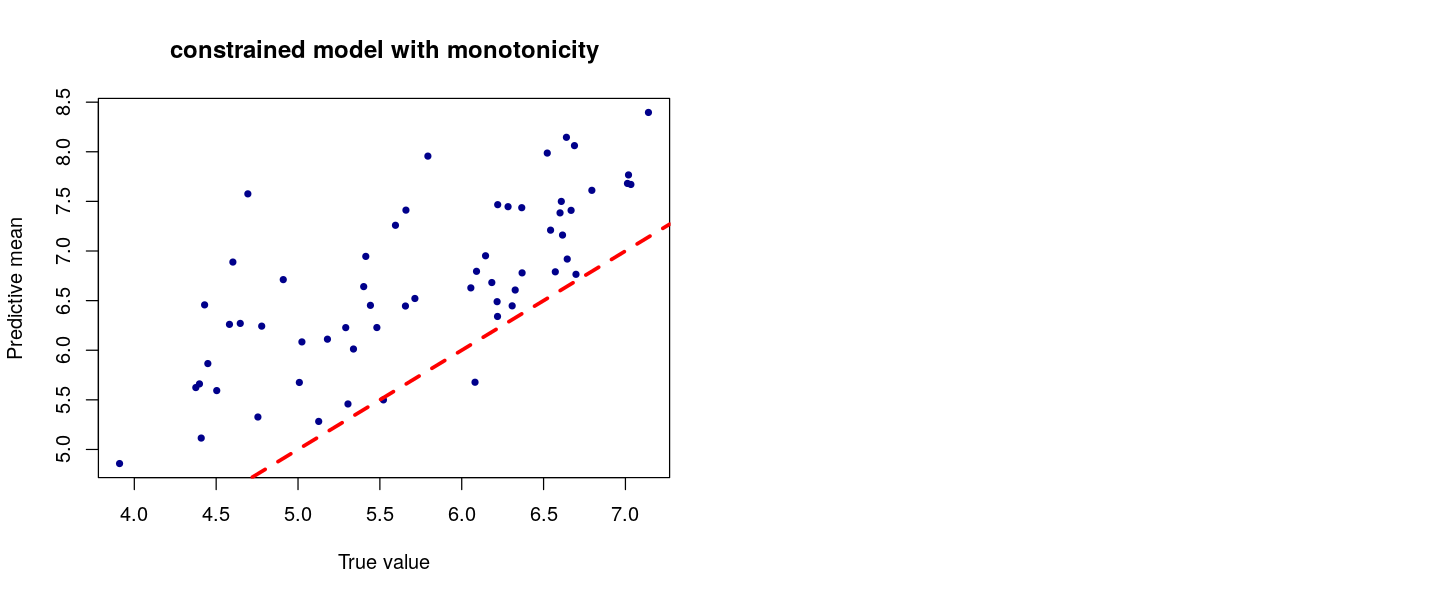

In [14]:
#### Assessing the quality of the predictive mean of the models ####
par(mfrow = c(1,2))
options(repr.plot.width = 12, repr.plot.height = 5)

plot(ytest, rowMeans(ysim),
     col = "darkblue", xlab = "True value", ylab = "Predictive mean",
     main = "constrained model with monotonicity", type = "p", pch = 20)
abline(a = 0, b = 1, col = "red", lty = 2, lwd = 3)